In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

plt.style.use('ggplot')
%matplotlib inline

In [2]:
np.__version__

'1.19.5'

In [3]:
import sklearn
sklearn.__version__

'0.20.3'

### 1. Get data using API

#### Step 1: Send request

In [ ]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
crypto = 'BTC'
limit = 2000
res = requests.get(endpoint + '?fsym=' + crypto + '&tsym=USD&limit=' + str(limit))

#### Step 2: Load data to the dataframe

In [ ]:
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist['date'] = pd.to_datetime(hist['time'], unit='s').dt.strftime('%Y-%m-%d')
hist = hist.drop(['time'], axis=1)
hist = hist.drop(['conversionSymbol', 'conversionType'], axis=1)
hist['crypto'] = crypto

target_col = 'close'
hist.head()

In [ ]:
# hist.shape

In [4]:
# hist = pd.read_csv('crypto_info_df')
# hist.rename(columns={'time': 'date'}, inplace=True)
# target_col = 'close'

### 2. Connect to the PostgreSQL & Create a Database

#### Step 1: Import the libraries

In [ ]:
# import sys to get more detailed Python exception info
import sys

# import the connect library for psycopg2
import psycopg2

# import the error handling libraries for psycopg2
from psycopg2 import OperationalError, errorcodes, errors

import psycopg2.extras as extras


#### Step 2: Specify the connection parameters

In [ ]:
# Note: please change your database, username & password as per your own values

conn_params_dic = {
    "host"      : "localhost",
    "user"      : "postgres",
    "password"  : "1103"
}

#### Step 3: Define a function that handles and parses psycopg2 exceptions

In [ ]:
def show_psycopg2_exception(err):
    # get details about the exception
    err_type, err_obj, traceback = sys.exc_info()

    # get the line number when exception occured
    line_n = traceback.tb_lineno

    # print the connect() error
    print ("\npsycopg2 ERROR:", err, "on line number:", line_n)
    print ("psycopg2 traceback:", traceback, "-- type:", err_type)

    # psycopg2 extensions.Diagnostics object attribute
    print ("\nextensions.Diagnostics:", err.diag)

    # print the pgcode and pgerror exceptions
    print ("pgerror:", err.pgerror)
    print ("pgcode:", err.pgcode, "\n")

#### Step 4: Define a connect function to connect to the PostgreSQL database server

In [ ]:
def connect(conn_params_dic):
    conn = None
    try:
        print('Connecting to the PostgreSQL...........')
        conn = psycopg2.connect(**conn_params_dic)
        print("Connection successful..................")
        
    except OperationalError as err:
        # pass exception to function
        show_psycopg2_exception(err)

        # set the connection to 'None' in case of error
        conn = None
    
    print()
    return conn

#### Step 5: Creates a database named crypto_db in PostgreSQL database

In [ ]:
db_name = 'crypto_db'

conn = connect(conn_params_dic)
conn.autocommit = True

if conn != None:
    
    try:
        cursor = conn.cursor();
        # Dropping database if exists
        cursor.execute("DROP DATABASE IF EXISTS " + db_name + ";")
    
        # Creating a database
        cursor.execute("CREATE DATABASE " + db_name + ";");
        print(db_name + " database is created successfully..................")
    
        # Closing the cursor & connection
        cursor.close()
        conn.close()
        
    except OperationalError as err:
        # pass exception to function
        show_psycopg2_exception(err)
        # set the connection to 'None' in case of error
        conn = None

### 3. Pandas DataFrame to PostgreSQL

#### Step 1: Add database name to the connection parameters

In [ ]:
conn_params_dic['database'] = db_name

#### Step 2. Identify data

In [ ]:
hist.dtypes

#### Step 3: Create a table named crypto_info in PostgreSQL database

In [ ]:
table_name = 'crypto_info'

conn = connect(conn_params_dic)
conn.autocommit = True

if conn != None:
    
    try:
        cursor = conn.cursor();
        # Dropping table if exists
        cursor.execute("DROP TABLE IF EXISTS " + table_name + ";")
        
        sql = '''CREATE TABLE crypto_info(
        id SERIAL PRIMARY KEY,
        date DATE NOT NULL,
        close NUMERIC(12, 2) NOT NULL, 
        high DECIMAL(12, 2) NOT NULL, 
        low DECIMAL(12, 2) NOT NULL, 
        open DECIMAL(12, 2) NOT NULL, 
        volumefrom DECIMAL(18, 2) NOT NULL, 
        volumeto DECIMAL(18, 2) NOT NULL,
        crypto CHAR(11) NOT NULL
        )'''
        
        # Creating a table
        cursor.execute(sql);
        print(table_name + " table is created successfully..................")
    
        # Closing the cursor & connection
        cursor.close()
        conn.close()
        
    except OperationalError as err:
        # pass exception to function
        show_psycopg2_exception(err)
        # set the connection to 'None' in case of error
        conn = None

#### Step 4: Define function to insert dataframe into table

In [ ]:
# Define function using psycopg2.extras.execute_batch() to insert the dataframe
def execute_batch(conn, datafrm, table, page_size=500):
    
    # Creating a list of tupples from the dataframe values
    tpls = [tuple(x) for x in datafrm.to_numpy()]
    
    # dataframe columns with Comma-separated
    cols = ', '.join(list(datafrm.columns))
    
    # SQL query to execute
    str_table_data = ', '.join("{}".format(data) for data in tpls)
    
    sql = "INSERT INTO {} ({}) VALUES {}".format(table, cols, str_table_data)

    cursor = conn.cursor()
    try:
        cursor.execute(sql)
        conn.commit()
        print("Data inserted using execute_batch() successfully...")
    except (Exception, psycopg2.DatabaseError) as err:
        # pass exception to function
        show_psycopg2_exception(err)
        cursor.close()

#### Step 5: List PostgreSQL tables

In [ ]:
# Print tables in a database
conn = connect(conn_params_dic)
conn.autocommit = True

cursor = conn.cursor()
get_tables_query = """SELECT table_schema, table_name
                        FROM information_schema.tables
                        WHERE (
                            table_schema = 'public'
                        )
                        ORDER BY table_schema, table_name;
                        """
cursor.execute(get_tables_query)
list_tables = cursor.fetchall()

print('PostgreSQL tables:')
for table_schema, table_name in list_tables:
    print("Table schema: {}, table name: {}". format(table_schema, table_name))

cursor.close()
conn.close()

#### Step 6: Perform data insertion to the table

In [ ]:
conn = connect(conn_params_dic)
conn.autocommit = True

cursor = conn.cursor()
execute_batch(conn, hist, table_name)

cursor.close()
conn.close()

#### Step 7: Output first 5 inserted rows

In [ ]:
# Print first 5 rows in a database
conn = connect(conn_params_dic)
conn.autocommit = True

cursor = conn.cursor()
try:
    cursor.execute("SELECT * from crypto_info LIMIT 5;")
    records = cursor.fetchall()
    for record in records:
        print(record)
except:
    print("Unable to SELECT")

cursor.close()
conn.close()

### 4. Data preprocessing

#### Step 1: Drop non numeric columns 

In [6]:
# numeric_hist = hist._get_numeric_data().copy()
numeric_hist = hist[[target_col]].copy()

#### Step 2: Split data on train and test

In [7]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [8]:
train, test = train_test_split(numeric_hist, test_size=0.2)

#### Step 3: Visualize data 

In [9]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

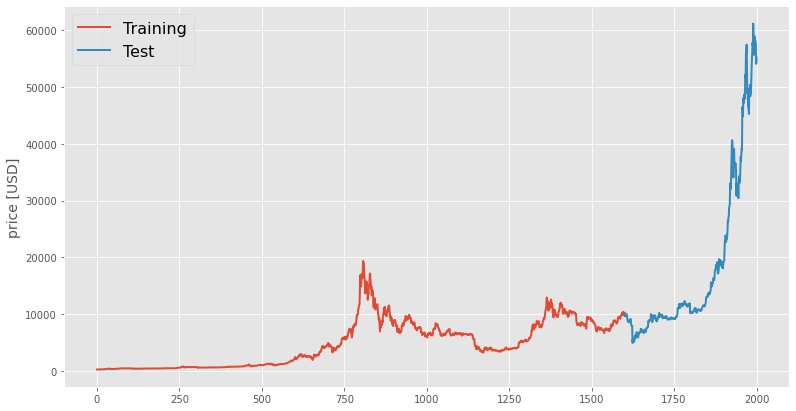

In [10]:
line_plot(train[target_col], test[target_col], 'Training', 'Test', title='')

 #### Step 4: Data normalization 

In [77]:
scaler = MinMaxScaler()

In [78]:
train_norm = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
test_norm = pd.DataFrame(scaler.transform(test), columns=test.columns)
# inverse_tranform

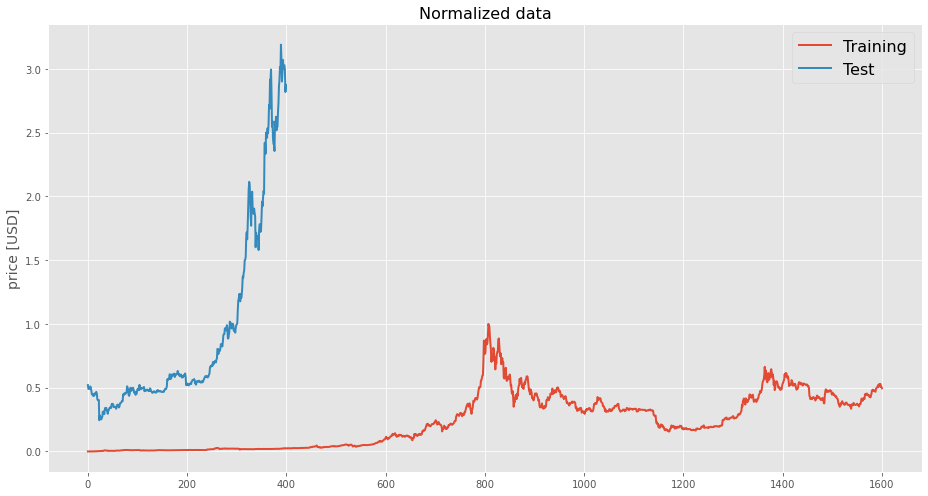

In [79]:
line_plot(train_norm[target_col], test_norm[target_col], 'Training', 'Test', title='Normalized data')

#### Step 5: Sliding window 

In [14]:
def extract_window_data(df, window_len=5):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        window_data.append(tmp.values)
    return np.array(window_data)

In [15]:
from db_config.config import ModelConfig
model_config = ModelConfig()

In [16]:
model_config.window_size

360

In [17]:
window_len = model_config.window_size
X_train = extract_window_data(train_norm, window_len)
X_test = extract_window_data(test_norm, window_len)

In [18]:
y_train = train_norm[target_col][window_len:].values
y_test = test_norm[target_col][window_len:].values

### 5. Building LSTM

#### Step 1: Initialize LSTM 

In [19]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

#### Step 2: Initialize params 

In [20]:
np.random.seed(42)
lstm_neurons = 100
epochs = 50
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

#### Step 3: Run LSTM 

In [21]:
X_train.shape

(1241, 360, 1)

In [22]:
model = build_lstm_model(
    X_train, 
    output_size=1, 
    neurons=lstm_neurons, 
    dropout=dropout, 
    loss=loss,
    optimizer=optimizer)

In [23]:
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    epochs=epochs, 
    batch_size=batch_size, 
    verbose=1, 
    shuffle=False)

Epoch 1/50
39/39 [==============================] - 7s 177ms/step - loss: 0.0076 - val_loss: 1.0252
Epoch 2/50
39/39 [==============================] - 7s 168ms/step - loss: 0.0092 - val_loss: 0.2049
Epoch 3/50
39/39 [==============================] - 6s 162ms/step - loss: 0.0020 - val_loss: 0.2624
Epoch 4/50
39/39 [==============================] - 6s 163ms/step - loss: 0.0020 - val_loss: 0.1721
Epoch 5/50
39/39 [==============================] - 6s 162ms/step - loss: 0.0018 - val_loss: 0.3160
Epoch 6/50
39/39 [==============================] - 7s 176ms/step - loss: 0.0022 - val_loss: 0.1278
Epoch 7/50
39/39 [==============================] - 7s 171ms/step - loss: 0.0017 - val_loss: 0.2684
Epoch 8/50
39/39 [==============================] - 7s 170ms/step - loss: 0.0017 - val_loss: 0.1503
Epoch 9/50
39/39 [==============================] - 7s 174ms/step - loss: 0.0016 - val_loss: 0.2812
Epoch 10/50
39/39 [==============================] - 7s 168ms/step - loss: 0.0018 - val_loss: 0.1604

In [24]:
X_test.shape

(40, 360, 1)

In [25]:
y_test[2]

2.5337127749652253

In [26]:
y_pred = model.predict(X_test).squeeze()
mean_absolute_error(y_pred, y_test)

0.33977104891436094

In [85]:
print("MAE = {}".format(scaler.inverse_transform(mean_absolute_error(y_pred, y_test).reshape(-1, 1))[0]))

MAE = [6729.32022407]


#### Step 4: Visualize training and validation loss 

In [27]:
plt.style.use('ggplot')

def plot_history(history):
#     acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(x, acc, 'b', label='Training acc')
#     plt.plot(x, val_acc, 'r', label='Validation acc')
#     plt.title('Training and validation accuracy')
#     plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

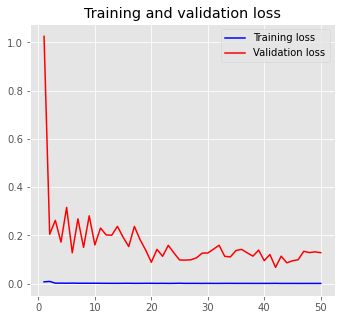

In [29]:
plot_history(history)

#### Step 5: Visualize prediction 

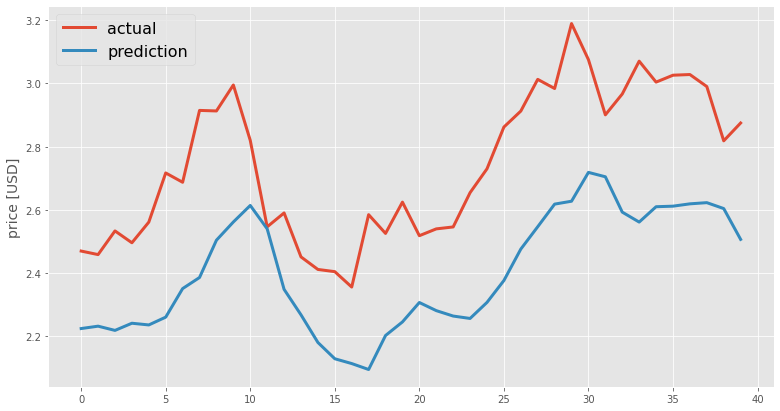

In [30]:
line_plot(y_test, y_pred, 'actual', 'prediction', lw=3)

#### Step 6: Model overview

In [67]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### 6. Tune LSTM

### 7. Recursive Multi-step Forecast 

### 8. Pipeline 

In [5]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [6]:
def y_pred_line_plot(line1, label1=None, title='Predicted stock prices', lw=2, save=False, save_path='\static', file_name = 'test.png'):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    
    if save:
        full_path = os.path.join(save_path, file_name)
        fig.savefig(full_path)

In [7]:
class CustomNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        inp_shape = X.shape
        X = X.reshape(-1, 1)
        X_norm = self.scaler.fit(X)
        X_norm = X_norm.reshape(inp_shape)
        return self
        
        
    def fit_transform(self, X, y=None):
        inp_shape = X.shape
        X = X.reshape(-1, 1)
        X_norm = (self.scaler).fit_transform(X)        
        X_norm = X_norm.reshape(inp_shape)
        return X_norm

    def transform(self, X, y=None):
        inp_shape = X.shape
        X = X.reshape(-1, 1)        
        X_trans = self.scaler.transform(X)
        X_trans = X_trans.reshape(inp_shape)
        return X_trans

In [8]:
def df_data_inv_transformer(scaler, transformed_data):
    data = scaler.inverse_transformer(transformed_data)
    return data

In [9]:
def lstm_stock_predictions(num_days, data, model):
    y_pred_arr = []
    for day in range(num_days):
        y_pred = model.predict(data)
        y_pred_arr.append(y_pred)
        push(data, y_pred)
        
    return y_pred_arr

In [10]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [11]:
# create a feature preparation pipeline for a model
def make_pipeline(model, input_data, output_size, neurons, dropout, loss, optimizer, epochs, batch_size, verbose=1, shuffle=False):
    steps = list()
    
    # normalization
    steps.append(('normalize', CustomNormalizer()))
    
    
    # the model
    steps.append(('model', KerasRegressor(
        build_fn=model, 
        input_data=input_data, 
        output_size=output_size, 
        neurons=neurons, 
        dropout=dropout, 
        loss=loss, 
        optimizer=optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose,
        shuffle=shuffle)))
    
    # create pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline

In [51]:
# window_len = model_config.window_size
# seed = 42
# np.random.seed(seed)
# lstm_neurons = 100
epochs = 25
# batch_size = 32
# loss = 'mse'
# dropout = 0.2
# optimizer = 'adam'

In [52]:
pipeline = make_pipeline(build_lstm_model,
                         input_data=X_train,
                         output_size=1,
                         neurons=lstm_neurons,
                         dropout=dropout,
                         loss=loss,
                         optimizer=optimizer,
                         epochs=epochs,
                         batch_size=batch_size)

In [53]:
X = extract_window_data(numeric_hist, window_len)
y = numeric_hist[target_col][window_len:].values

In [54]:
scaler = MinMaxScaler()
scaler.fit(X.reshape(-1, 1))

y = scaler.transform(y.reshape(-1, 1)).reshape(y.shape)

In [55]:
pipeline.fit(X, y)

Epoch 1/25
52/52 [==============================] - 9s 168ms/step - loss: 0.0030
Epoch 2/25
52/52 [==============================] - 8s 155ms/step - loss: 0.0036
Epoch 3/25
52/52 [==============================] - 8s 161ms/step - loss: 0.0052
Epoch 4/25
52/52 [==============================] - 8s 161ms/step - loss: 0.0037
Epoch 5/25
52/52 [==============================] - 9s 166ms/step - loss: 0.0013
Epoch 6/25
52/52 [==============================] - 8s 161ms/step - loss: 0.0019
Epoch 7/25
52/52 [==============================] - 8s 163ms/step - loss: 0.0041
Epoch 8/25
52/52 [==============================] - 9s 172ms/step - loss: 0.0024
Epoch 9/25
52/52 [==============================] - 9s 171ms/step - loss: 0.0017
Epoch 10/25
52/52 [==============================] - 9s 170ms/step - loss: 0.0025
Epoch 11/25
52/52 [==============================] - 8s 161ms/step - loss: 0.0046
Epoch 12/25
52/52 [==============================] - 9s 168ms/step - loss: 0.0023
Epoch 13/25
52/52 [======

Pipeline(memory=None,
     steps=[('normalize', CustomNormalizer()), ('model', <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000019DCED40EF0>)])

### 9. Save scaler and pipeline 

In [56]:
import joblib

from keras.models import load_model
# import pickle
# import cloudpickle

In [57]:
save_models_path = "../coursework_project_64/models/"

In [58]:
joblib.dump(scaler, save_models_path + 'min_max_scaler.pkl')
# scaler = joblib.load('min_max_scaler.pkl')

# Save the Keras model first:
pipeline.named_steps['model'].model.save(save_models_path + 'lstm_keras_model.h5')

# This hack allows us to save the sklearn pipeline:
pipeline.named_steps['model'].model = None

# Finally, save the pipeline:
joblib.dump(pipeline, save_models_path + 'lstm_pipeline.pkl')


['../coursework_project_64/models/lstm_pipeline.pkl']

# Flask

In [12]:
from flask import Flask, render_template, redirect, url_for, request
from flask_sqlalchemy import SQLAlchemy
from db_config.config import DBConfig, ModelConfig
from pipe_config.utils import CustomNormalizer
import keras
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from datetime import datetime
rcParams.update({'figure.autolayout': True})

C:\ProgramData\Anaconda3\lib\site-packages\flask_sqlalchemy\__init__.py:873: FSADeprecationWarning: SQLALCHEMY_TRACK_MODIFICATIONS adds significant overhead and will be disabled by default in the future.  Set it to True or False to suppress this warning.
  'SQLALCHEMY_TRACK_MODIFICATIONS adds significant overhead and '


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [19/May/2021 16:19:55] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/May/2021 16:20:06] "POST /input_form HTTP/1.1" 302 -


1/1 [==============================] - 0s 1ms/step


127.0.0.1 - - [19/May/2021 16:20:07] "GET /success/5 HTTP/1.1" 200 -
127.0.0.1 - - [19/May/2021 16:20:07] "GET /static/btc_pred_2021-05-19-16:20.png HTTP/1.1" 200 -
127.0.0.1 - - [19/May/2021 20:09:56] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/May/2021 20:10:22] "POST /input_form HTTP/1.1" 302 -


1/1 [==============================] - 0s 998us/step


127.0.0.1 - - [19/May/2021 20:10:24] "GET /success/25 HTTP/1.1" 200 -
127.0.0.1 - - [19/May/2021 20:10:24] "GET /static/btc_pred_2021-05-19-20:10.png HTTP/1.1" 200 -


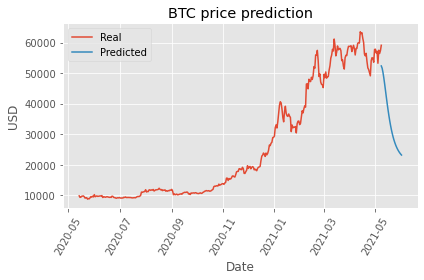

In [19]:
db_config = DBConfig()
model_config = ModelConfig()

app = Flask(__name__)
app.config['SEND_FILE_MAX_AGE_DEFAULT'] = 0
app.config['SQLALCHEMY_DATABASE_URI'] = db_config.get_uri()
db = SQLAlchemy(app)


class CryptoInfo(db.Model):

    __tablename__ = "crypto_info"

    id = db.Column(db.Integer(), primary_key=True)
    date = db.Column(db.DateTime())
    close = db.Column(db.Float())
    high = db.Column(db.Float())
    low = db.Column(db.Float())
    open = db.Column(db.Float())
    volumefrom = db.Column(db.Float())
    volumeto = db.Column(db.Float())
    crypto = db.Column(db.String(11))


save_models_path = "../coursework_project_64/models/"
scaler = joblib.load(save_models_path + 'min_max_scaler.pkl')

pipeline = joblib.load(save_models_path + 'lstm_pipeline.pkl')

pipeline.named_steps['model'].model = keras.models.load_model(save_models_path + 'lstm_keras_model.h5')


# Query data
crypto_query_close = db.session.query(CryptoInfo.close).order_by(CryptoInfo.date.desc()).limit(model_config.window_size).all()
crypto_query_date = db.session.query(CryptoInfo.date).order_by(CryptoInfo.date.desc()).limit(model_config.window_size).all()


# Data to array
crypto_close = [val for val, in crypto_query_close]
crypto_date = [val for val, in crypto_query_date]
crypto_close.reverse()
crypto_date.reverse()


# Push to the end and pop first
def push(x, y):
    x.pop(0)
    x.append(y)
    return x


@app.route('/success/<n_days>')
def success(n_days):
    n_days = int(n_days)
    
    crypto_close_to_pred = crypto_close.copy()
    
    # Result close and date arrays
    close_pred = []
    date_pred = pd.date_range(crypto_date[-1], periods=n_days).tolist()
    
    for day in range(n_days):
        input_crypto_close = np.reshape(crypto_close_to_pred, (1, model_config.window_size, 1))
        
        curr_close_pred = pipeline.predict(input_crypto_close)       
        curr_close_pred_rescaled = scaler.inverse_transform(curr_close_pred.reshape(-1, 1))
        
        close_pred.append(curr_close_pred_rescaled.item())
        crypto_close_to_pred = push(crypto_close_to_pred, curr_close_pred_rescaled.item())
        
    table_data = [[date_pred[i], close_pred[i]] for i in range(n_days)]
    
    plt.close()
    
    # Plot window and predicted values
    plt.plot(crypto_date, crypto_close, label="Real")
    plt.plot(date_pred, close_pred, label="Predicted")
    plt.title('BTC price prediction')
    plt.xticks(rotation=60)
    plt.xlabel("Date")
    plt.ylabel("USD")
    plt.legend()
    plt.tight_layout()
    
    img_path = 'static/'
    img_timestamp = datetime.now().strftime("%Y-%m-%d-%H:%M")
    img_name = 'btc_pred_' + img_timestamp + '.png'
    
    plt.savefig(img_path + img_name)
    
    return render_template('table_date_predict.html', tabledata=table_data, filename=img_name)


@app.route('/')
def index():
    return render_template("index.html")


@app.route('/input_form', methods=['POST', 'GET'])
def get_n_days():
    if request.method == 'POST':
        n_days = request.form['n_days']
        return redirect(url_for('success', n_days=n_days))
    else:
        n_days = request.args.get('n_days')
        return redirect(url_for('success', n_days=n_days))

    
@app.after_request
def add_header(response):
    # response.cache_control.no_store = True
    response.headers['Cache-Control'] = 'no-store, no-cache, must-revalidate, post-check=0, pre-check=0, max-age=0'
    response.headers['Pragma'] = 'no-cache'
    response.headers['Expires'] = '-1'
    return response
    
    
if __name__ == '__main__':
    app.run()


In [61]:
# save_models_path = "../coursework_project_64/models/"
# scaler = joblib.load(save_models_path + 'min_max_scaler.pkl')

# pipeline = joblib.load(save_models_path + 'lstm_pipeline.pkl')

# pipeline.named_steps['model'].model = load_model(save_models_path + 'lstm_keras_model.h5')
